# Prediction of purchasing behavior
Demonstrate the complete process from **Data Generation → EDA → Baseline Model** with synthetic customer behavior data.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
)
from sklearn.compose import ColumnTransformer

## 1.Synthetic Data 
 
Model 7 features such as age, length of stay, and history of purchase based on business intuition and calculate the probability of purchase.  
The dataset can be easily scaled up with the `n_samples` parameter.

In [2]:
def generate_customer_data(n_samples: int = 5000, random_state: int = 42):
    """Generate synthetic customer data for purchase prediction."""
    if n_samples <= 0:
        raise ValueError("n_samples must be positive")

    rng = np.random.default_rng(random_state)

    age = rng.normal(40, 15, n_samples).clip(18, 80)
    time_spent_on_site = rng.exponential(5, n_samples)
    pages_visited = rng.poisson(5, n_samples).clip(1)

    is_returning_customer = rng.binomial(1, 0.35, n_samples)
    previous_purchases = (
        rng.poisson(1, n_samples) + is_returning_customer * rng.poisson(2, n_samples)
    )

    cart_value = rng.exponential(60, n_samples)
    days_since_last_visit = rng.exponential(25, n_samples)

    purchase_prob = (
        0.03
        + 0.001 * (age - 30)
        + 0.06 * np.tanh(time_spent_on_site / 10)  # saturation effect
        + 0.02 * pages_visited
        + 0.12 * np.log1p(previous_purchases)
        + 0.0012 * cart_value
        + 0.25 * is_returning_customer
        - 0.0025 * days_since_last_visit
    ).clip(0, 0.95)

    purchased = rng.binomial(1, purchase_prob)

    return pd.DataFrame({
        "age": age,
        "time_spent_on_site": time_spent_on_site,
        "pages_visited": pages_visited,
        "previous_purchases": previous_purchases,
        "cart_value": cart_value,
        "is_returning_customer": is_returning_customer,
        "days_since_last_visit": days_since_last_visit,
        "purchased": purchased,
    })


In [3]:
df = generate_customer_data()
display(df.head())     
print("sample size:", len(df))

,age,time_spent_on_site,pages_visited,previous_purchases,cart_value,is_returning_customer,days_since_last_visit,purchased
0,44.570756,3.263619,3,4,9.601794,1,10.710255,1
1,24.400238,4.624865,9,2,65.301276,0,16.382240,1
2,51.256768,2.184283,5,2,29.024231,0,6.488114,0
3,54.108471,7.801218,8,1,41.966801,0,69.970533,0
4,18.000000,0.571957,5,1,19.990359,0,125.557399,0


sample size: 5000


## 2. Exploratory Data Analysis (EDA)

In this section, through *Statistical Overview*, *Missing Value Detection*, *Numerical Characteristic Distributions*, and *Correlation Heatmaps*.
This section provides a quick overview of data quality and relationships between variables to provide an intuitive basis for subsequent modeling.

In [4]:
import warnings
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid", palette="husl")
warnings.filterwarnings("ignore", category=FutureWarning)

palette = {0: "#1f77b4",  
           1: "#ff7f0e"} 

def run_basic_eda(df, target="purchased", features=None, bins=20):
    """
    Perform basic EDA: statistics, missing values, target distribution,
    feature distributions, and correlation heatmap.
    """
    if df.empty:
        raise ValueError("Input DataFrame is empty – cannot perform EDA.")

    #1. Statistics & Missing values
    display(df.describe().T.style.format(precision=2))  
    mis = df.isnull().sum()
    print("Missing values per column:\n", mis[mis > 0] if mis.any() else "✅ No missing values")

    #2. Target distribution
    if target in df.columns:
        print("\nTarget distribution (%):")
        print(df[target].value_counts(normalize=True).mul(100).round(2))
    else:
        warnings.warn(f"Target '{target}' not found in DataFrame → skip target plots.")
        target = None

    #3. Numeric feature histograms
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    if target and target in num_cols:
        num_cols.remove(target)

    if features is None:
        features = num_cols
    else:
        # Keep only existing columns
        missing_feats = [c for c in features if c not in df.columns]
        if missing_feats:
            warnings.warn(f"These features were not found and will be skipped: {missing_feats}")
        features = [c for c in features if c in df.columns]

    n = len(features)
    if n == 0:
        warnings.warn("No numeric features to plot.")
    else:
        n_cols = 2
        n_rows = int(np.ceil(n / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
        axes = axes.flatten()

        for ax, feat in zip(axes, features):
            sns.histplot(
                data=df,
                x=feat,
                hue=target,
                bins=bins,
                kde=True,
                ax=ax,
                alpha=0.75,
                palette=palette,  
                hue_order=[1, 0],  
            )
            ax.set_title(f"{feat} vs. {target}" if target else feat)
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:,.0f}"))

        # Remove any unused axes
        for ax in axes[n:]:
            ax.remove()

        plt.tight_layout()
        plt.show()

    #4. Correlation heatmap
    if len(num_cols) >= 2:
        corr = df[num_cols + ([target] if target else [])].corr()
        mask = np.triu(np.ones_like(corr, dtype=bool))
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            corr,
            mask=mask,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            linewidths=0.5,
            cbar_kws=dict(shrink=0.85),
        )
        plt.title("Correlation Matrix")
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.show()



,count,mean,std,min,25%,50%,75%,max
age,5000.00,40.19,13.97,18.00,29.62,39.94,49.47,80.00
time_spent_on_site,5000.00,4.96,4.99,0.00,1.43,3.38,6.84,44.79
pages_visited,5000.00,5.05,2.26,1.00,3.00,5.00,6.00,15.00
previous_purchases,5000.00,1.70,1.63,0.00,0.00,1.00,3.00,11.00
cart_value,5000.00,60.88,59.87,0.01,17.25,42.49,84.93,442.24
is_returning_customer,5000.00,0.35,0.48,0.00,0.00,0.00,1.00,1.00
days_since_last_visit,5000.00,25.13,25.14,0.02,7.38,17.66,34.51,224.65
purchased,5000.00,0.36,0.48,0.00,0.00,0.00,1.00,1.00


Missing values per column:
 ✅ No missing values

Target distribution (%):
purchased
0    64.48
1    35.52
Name: proportion, dtype: float64


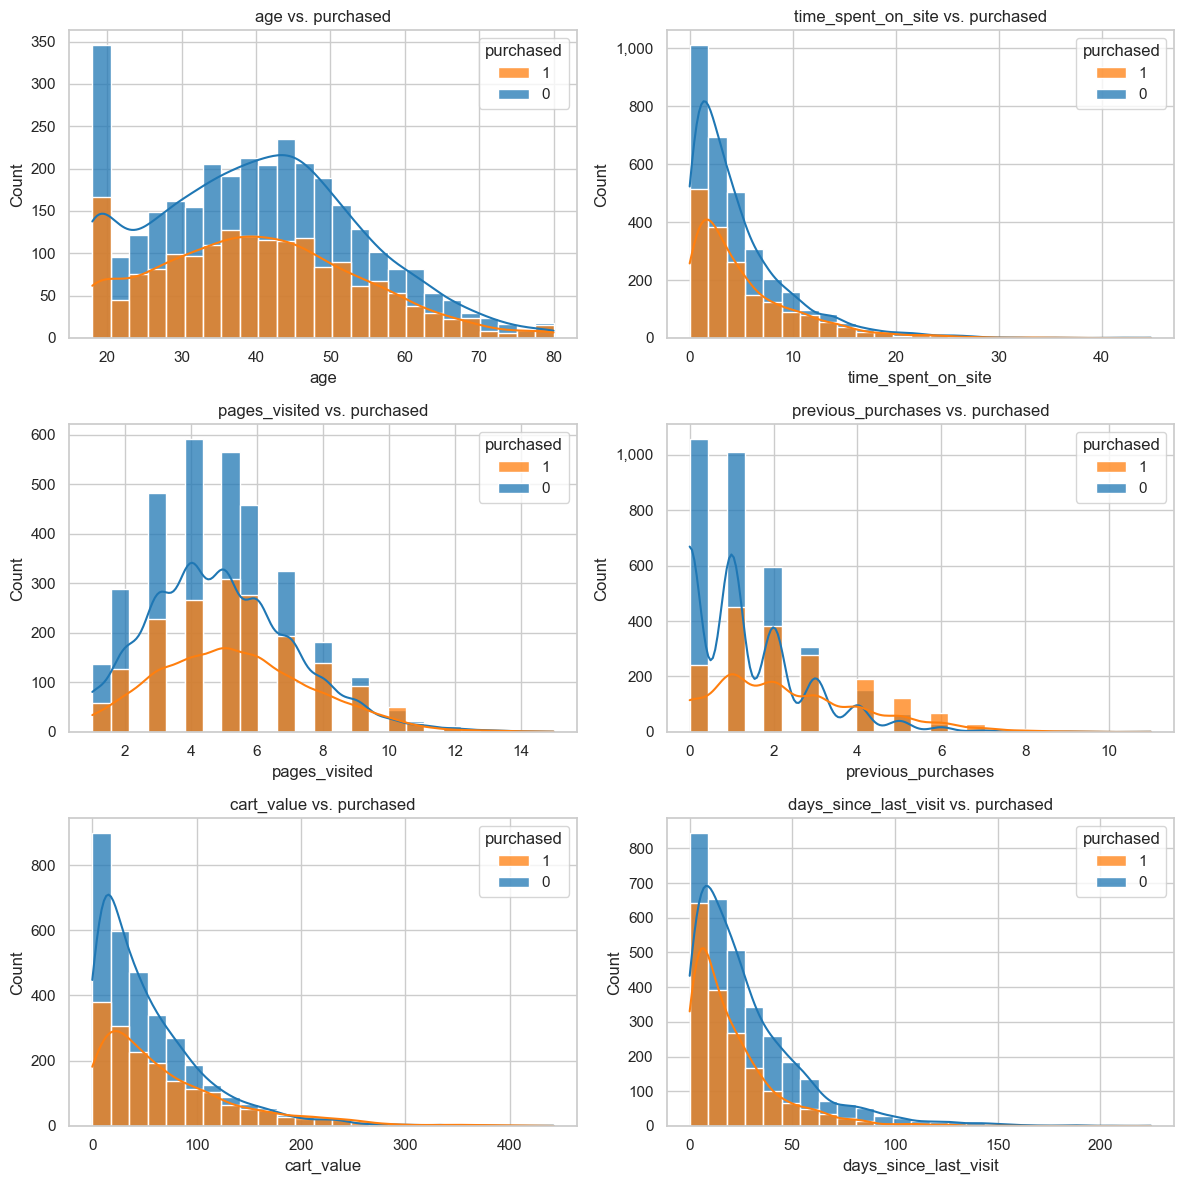

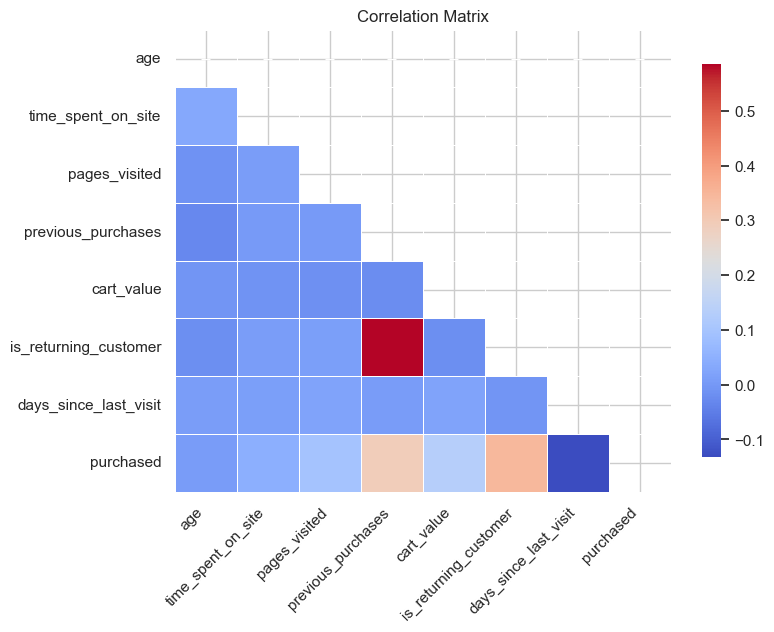

In [5]:
# create data
customer_data = generate_customer_data()

# run EDA
run_basic_eda(
    customer_data,                        
    target="purchased",
    features=["age", "time_spent_on_site", "pages_visited",
              "previous_purchases", "cart_value", "days_since_last_visit"],
    bins=25,
)

### 3. Feature Engineering & Logistic Regression

**New features**  
- `recency_score` = 1 / (1 + days_since_last_visit)  
- `engagement_score` = (time_spent_on_site × pages_visited) / 10

**Workflows**  
1. duplicate original table → `add_features()` add columns and prevent nulls  
2. `train_test_split` keep 80 / 20 + stratify  
3. Pipeline → `StandardScaler` + `LogisticRegression  
4. Export coefficients and sort by absolute value

In [12]:
# Feature engineering 
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add engineered features to a copy of the input DataFrame.

    - recency_score  = 1 / (1 + days_since_last_visit)
    - engagement_score  = time_spent_on_site * pages_visited / 10
    Returns the enriched DF.
    """
    required_cols = {
        "days_since_last_visit",
        "time_spent_on_site",
        "pages_visited",
    }
    missing = required_cols - set(df.columns)
    if missing:
        raise KeyError(f"Missing required columns for feature engineering: {missing}")

    df = df.copy()  # Avoid modifying the original table
    # Divide-zero protection
    df["recency_score"] = 1 / (1 + df["days_since_last_visit"].fillna(0))

    df["engagement_score"] = (
        df["time_spent_on_site"].fillna(0) * df["pages_visited"].fillna(0)
    ) / 10

    return df
# Data Splitting & Pipeline Building
def prepare_data_and_model(df: pd.DataFrame, target: str = "purchased"):
    if df.empty:
        raise ValueError("Input DataFrame is empty – cannot proceed.")

    if target not in df.columns:
        raise KeyError(f"Target column '{target}' not found in DataFrame.")

    df_fe = add_features(df)

    X = df_fe.drop(columns=[target])
    y = df_fe[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set:     {len(X_test)} samples")

    pipe = Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            ("classifier", LogisticRegression(max_iter=1000, random_state=42)),
        ]
    )

    pipe.fit(X_train, y_train)
    return pipe, X_train, X_test, y_train, y_test


# Output feature coefficients
pipeline, X_train, X_test, y_train, y_test = prepare_data_and_model(customer_data)


model = pipeline.named_steps["classifier"]
coefficients = (
    pd.DataFrame(
        {
            "Feature": X_train.columns,
            "Coefficient": model.coef_[0],
        }
    )
    .assign(Abs=lambda d: d["Coefficient"].abs())
    .sort_values("Abs", ascending=False)
    .drop(columns="Abs")
    .reset_index(drop=True)
)

print("\nFeature Importance (sorted by absolute weight):")
print(coefficients)

Training set: 4000 samples
Test set:     1000 samples

Feature Importance (sorted by absolute weight):
                 Feature  Coefficient
0  is_returning_customer     0.558644
1  days_since_last_visit    -0.375912
2             cart_value     0.354848
3     previous_purchases     0.350942
4          pages_visited     0.217978
5     time_spent_on_site     0.074769
6       engagement_score     0.059230
7                    age     0.055846
8          recency_score     0.043328


### 5. Model Evaluation
*Precision / Recall / F1:*  Separate measures of correctness, coverage, and reconciliation of the two; F1 is more friendly to unbalanced data.   
*Confusion Matrix:* TP / FP / FN / TN Four-panel visualization of categorization error types.   
*ROC & AUC:*  The curves show the change of TPR-FPR under different thresholds; AUC close to 1 means the model is better.    
*Cross‑validation:*  5 fold Stratified CV test robustness, output mean ± standard deviation.   

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       645
           1       0.68      0.50      0.58       355

    accuracy                           0.74      1000
   macro avg       0.72      0.69      0.69      1000
weighted avg       0.73      0.74      0.73      1000



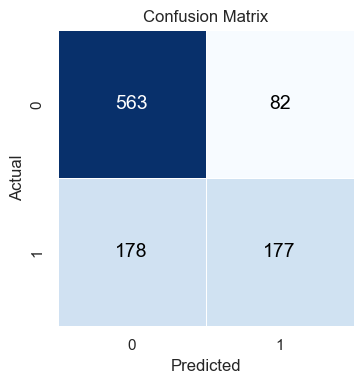

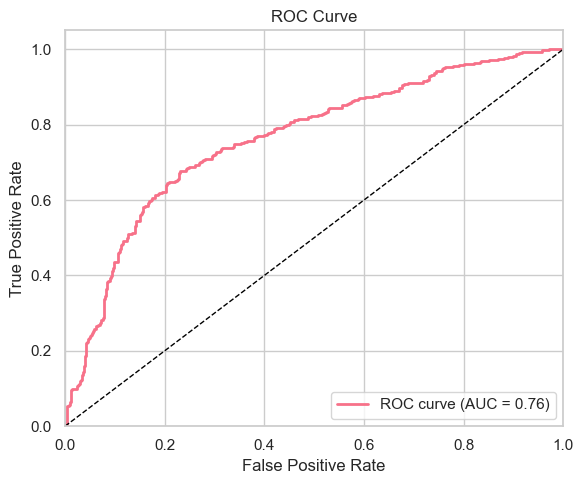

Cross‑validation accuracy: 0.72 (+/- 0.02)


In [16]:
# Fault tolerance: checking for the existence of an object
if "pipeline" not in globals():
    raise NameError(" Variable 'pipeline' was not found, please complete the model training steps first.")
if "X_test" not in globals() or "y_test" not in globals():
    raise NameError(" Test set (X_test, y_test) is not loaded. Please make sure that the data splitting code has been executed.")

# predictions
y_pred = pipeline.predict(X_test)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=2))

# Confusion Matrix Visualization

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    cm,
    cmap="Blues",
    cbar=False,
    ax=ax,
    square=True,        
    linewidths=0.5,
)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j + 0.5,
            i + 0.5,
            f"{cm[i, j]:d}",
            ha="center",
            va="center",
            fontsize=14,
            color="white" if cm[i, j] > thresh else "black",
        )

ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC 
plt.figure(figsize=(6, 5))
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", lw=2)
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# cross-validation
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="accuracy")

print(
    f"Cross‑validation accuracy: {cv_scores.mean():.2f} "
    f"(+/- {cv_scores.std():.2f})"
)

### 6. Explanatory & Business Insights

1. **bar chart**  
   * Green bar: positive drive; red bar: negative suppression  
   * Separated by baseline 0 - the farther away from 0, the greater the effect  
2. **Odds Ratio**  
   * OR > 1 → multiply the chances of purchase  
   * OR < 1 → Purchase chance is reduced  

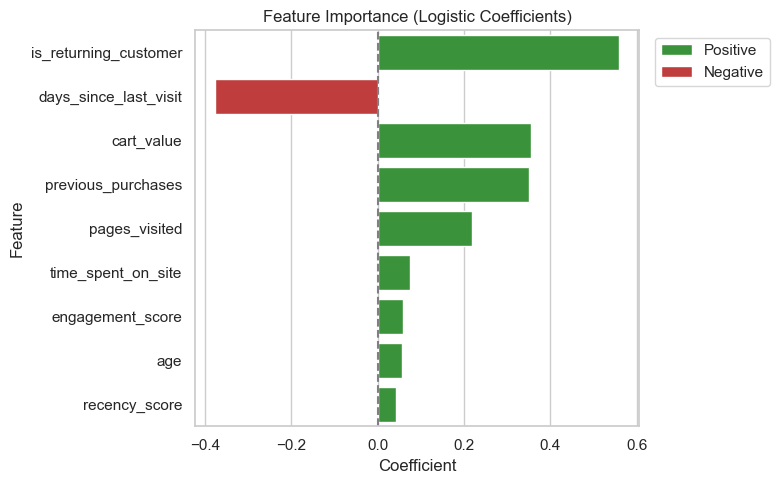


Odds Ratios (impact on purchase odds):
              Feature  Coefficient  Odds_Ratio
is_returning_customer        0.559       1.748
           cart_value        0.355       1.426
   previous_purchases        0.351       1.420
        pages_visited        0.218       1.244
   time_spent_on_site        0.075       1.078
     engagement_score        0.059       1.061
                  age        0.056       1.057
        recency_score        0.043       1.044
days_since_last_visit       -0.376       0.687


In [17]:
# Fault tolerance
if "coefficients" not in globals():
    raise NameError("Variable 'coefficients' is missing. "
                    "Make sure you have trained the model and built the "
                    "'coefficients' DataFrame first.")

if "model" not in globals():
    raise NameError("Logistic‑regression object 'model' not found.")

# Feature‑importance barplot 
coef_df = coefficients.copy()          # columns: Feature, Coefficient
coef_df["Sign"] = np.where(coef_df["Coefficient"] >= 0, "Positive", "Negative")

plt.figure(figsize=(8, 5))
sns.barplot(
    data=coef_df,
    y="Feature",
    x="Coefficient",
    hue="Sign",
    dodge=False,
    palette={"Positive": "#2ca02c", "Negative": "#d62728"},
)
plt.axvline(0, color="gray", linestyle="--")
plt.title("Feature Importance (Logistic Coefficients)")
plt.legend(title="", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Odds‑ratio table 
odds_ratios = coef_df.assign(Odds_Ratio=lambda d: np.exp(d["Coefficient"]))

print("\nOdds Ratios (impact on purchase odds):")
print(
    odds_ratios[["Feature", "Coefficient", "Odds_Ratio"]]
    .sort_values("Odds_Ratio", ascending=False)
    .to_string(index=False, float_format="%.3f")
)

## 7. New User Prediction & Model Saving

1. **`predict_purchase_probability()`**  
   - Receive original customer characteristics  
   - Add `recency_score`, `engagement_score`  automatically.
   - Zero alignment in training column order , then mark `predict_proba` 
2. **example**：Print key columns for different profiled users 
3. **future use**：`joblib.dump(pipeline, 'purchase_prediction_model.pkl')`  
   - Deployment environment → `model = joblib.load(...)`  



In [ ]:
# 1. Predictive Functions -- Autocomplete Features & Align in Training Order                          #

def predict_purchase_probability(new_customer_df: pd.DataFrame, pipe, feat_func=add_features,
                                 proba_threshold: float = 0.5) -> pd.DataFrame:
    """
    Predict purchase probability for new customers using a trained pipeline.

    Parameters
    ----------
    new_customer_df : pd.DataFrame
        Raw feature table for new customers.
    pipe : sklearn Pipeline
        Trained pipeline (must support `predict_proba` and expose `feature_names_in_`).
    feat_func : callable
        Function that adds engineered features; defaults to `add_features` defined earlier.
    proba_threshold : float, default=0.5
        Cut‑off for 'likely_to_purchase'.

    Returns
    -------
    pd.DataFrame
        Original data + engineered features + `purchase_probability` + `likely_to_purchase`.
    """
    if new_customer_df.empty:
        raise ValueError("new_customer_df is empty — nothing to predict.")

    if not hasattr(pipe, "predict_proba"):
        raise AttributeError("Provided pipeline has no predict_proba method.")

    # 1) Copy & Add Engineering Features
    df = feat_func(new_customer_df)

    # 2) Aligns with training columns, missing columns are filled in 0 / nan → 0
    train_cols = list(pipe.feature_names_in_)
    for col in train_cols:
        if col not in df.columns:
            df[col] = 0
    df = df[train_cols]         # Rearrange in the correct order

    # 3)generation probability
    prob = pipe.predict_proba(df)[:, 1]
    df_out = new_customer_df.copy()
    df_out["purchase_probability"] = prob
    df_out["likely_to_purchase"] = prob >= proba_threshold

    return df_out


# 2. example                    

new_customers = pd.DataFrame({
    "age": [25, 45, 65],
    "time_spent_on_site": [2, 8, 1],
    "pages_visited": [3, 12, 2],
    "previous_purchases": [0, 5, 1],
    "cart_value": [20, 150, 30],
    "is_returning_customer": [0, 1, 1],
    "days_since_last_visit": [0, 5, 60],
})

predictions = predict_purchase_probability(new_customers, pipeline)

print("\nPurchase Predictions:")
print(
    predictions[
        ["age", "previous_purchases", "purchase_probability", "likely_to_purchase"]
    ].to_string(index=False, float_format="%.3f")
)

# 3. Save model 
MODEL_PATH = "purchase_prediction_model.pkl"
joblib.dump(pipeline, MODEL_PATH)
print(f"\n Pipeline saved to '{MODEL_PATH}'")


Purchase Predictions:
 age  previous_purchases  purchase_probability  likely_to_purchase
  25                   0                 0.191               False
  45                   5                 0.923                True
  65                   1                 0.243               False

✅  Pipeline saved to 'purchase_prediction_model.pkl'
